# Mount Google Drive

In [134]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Install Required Libraries

In [135]:
!pip3 --no-cache-dir install dadmatools numpy pandas matplotlib scikit-learn hazm wordcloud_fa nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import numpy as np
import pandas as pd
pd.options.plotting.backend = "matplotlib"

import matplotlib.pyplot as plt

# Read Raw Data

In [3]:
labelled_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SAMousavizade/data_labelled.csv")
unlabelled_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SAMousavizade/data_unlabelled.csv")

# labelled_data = pd.read_csv("data_labelled.csv")
# unlabelled_data = pd.read_csv("data_unlabelled.csv")

labelled_data

,id,text,label
0,131244574,عالی عالی عالی عالی عالی عالی عالی عالی عالی ع...,0
1,133141894,دوستان این نظرات و پیشنهادات رو باید به پشتیبا...,0
2,94129372,خیلی ایراد داره مسخره تر از این نمیشه رقیب‌هات...,1
3,131334220,نه کی گفته خرابه من دارم باهاش کار میکنم از من...,0
4,131387172,سلام عالیه حتما نصب کنید از کالاف دیوتی هم بهتره,0
...,...,...,...
3591,94229465,همه رشته ها نداره مثلا معارف سوالات تخصصي ندار...,1
3592,131571104,خیلی بده من اصلا. دوست ندارم خواهش می کنم دانل...,0
3593,132784715,بهترین برنا مه ای که دیدم خیلی باهاله میتونی ت...,0
3594,131981378,خیلی بازی مسخره هس نصب نکنید ۱ستاره هم براش زیاده,0


# Class Imbalance

Plot following category to get insight about imbalance in label categories.

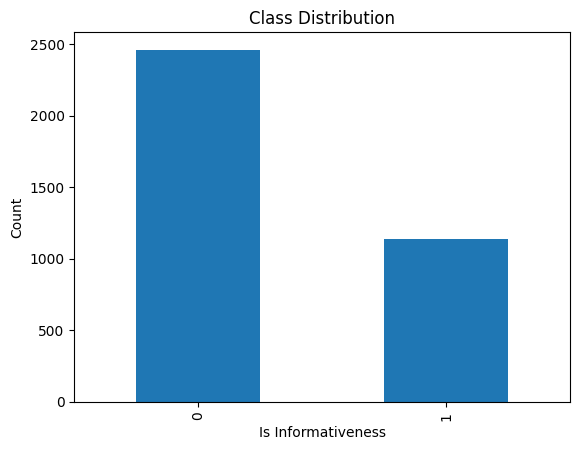

In [4]:
pd.options.plotting.backend = 'matplotlib'

labelled_data.groupby("label")["label"].count().plot(kind="bar",)
plt.title("Class Distribution")
plt.xlabel("Is Informativeness")
plt.ylabel("Count")
plt.show()

In [5]:
labelled_data.groupby("label")["label"].count()

label
0    2460
1    1136
Name: label, dtype: int64

# Plot Word Cloud

Plot word cloud of each category texts in labelled data to get insight about most repeatitive words and n-grams.

# Preprocess Raw Data

In this section, I preprocess raw-text data. Text preprocessing steps are as follows:

- Unifying all variants of characters (like "ی" and "ي")
- Remove extra spaces between tokens 
- Remove punctuations(like !, ., ?, etc)
- Remove HTML tags  
- Remove all emails, phone numbers, URLs, emojis
- Remove stop-words 
-  Refine any characters being repeated more than 2 times in the tokens (like "عااااااااالیه" to "عاالیه"
- Lemmatization (grouping the inflected forms of a word so they can be analyzed as a single item.)

In [139]:
from dadmatools.models.normalizer import Normalizer

normalizer = Normalizer(
    full_cleaning=False,
    unify_chars=True,
    refine_punc_spacing=True,
    remove_extra_space=True,
    remove_puncs=True,
    remove_html=True,
    remove_stop_word=True,
    replace_email_with="",
    replace_number_with="",
    replace_url_with="",
    replace_mobile_number_with="",
    replace_emoji_with="",
    replace_home_number_with=""
)

labelled_data["normalized_text"] = labelled_data["text"].apply(lambda text: normalizer.normalize(text))
labelled_data["normalized_text"] = labelled_data["normalized_text"].replace(r'(.)\1{2,}', '', regex=True)

unlabelled_data["normalized_text"] = unlabelled_data["text"].apply(lambda text: normalizer.normalize(text))
unlabelled_data["normalized_text"] = unlabelled_data["normalized_text"].replace(r'(.)\1{2,}', '', regex=True)

In [141]:
from hazm import Normalizer, sent_tokenize, word_tokenize, Stemmer, Lemmatizer, POSTagger, Chunker, tree2brackets, DependencyParser, stopwords_list

lemmatizer = Lemmatizer()

informative_text_tokens = [list(map(lemmatizer.lemmatize, word_tokenize(text))) for text in labelled_data[labelled_data["label"] == 1]["normalized_text"]]
non_informative_text_tokens = [list(map(lemmatizer.lemmatize, word_tokenize(text))) for text in labelled_data[labelled_data["label"] == 0]["normalized_text"]]

and plot word cloud as follows:

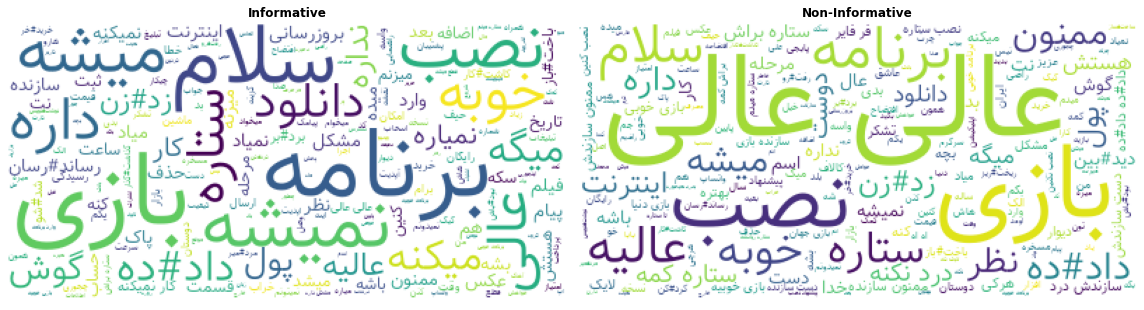

In [157]:
import itertools

def aggregate_tokens(tokens_list_of_list: pd.Series):
    return list(itertools.chain.from_iterable(tokens_list_of_list))

from wordcloud_fa import WordCloudFa

wc_bg_color = "white"

informative_word_cloud = WordCloudFa(persian_normalize=True, include_numbers=False, background_color=wc_bg_color,).generate(
    " ".join(aggregate_tokens(informative_text_tokens))
)
                            
non_informative_word_cloud = WordCloudFa(persian_normalize=True, include_numbers=False, background_color=wc_bg_color,).generate(
    " ".join(aggregate_tokens(non_informative_text_tokens))
)

plt.figure(figsize=(16, 8 ))

plt.subplot(1, 2, 1)
plt.imshow(informative_word_cloud)
plt.title('Informative', fontweight="bold")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(non_informative_word_cloud)
plt.title('Non-Informative', fontweight="bold")
plt.axis('off')

plt.tight_layout()
plt.show()